# Project

## Import libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import statistics
import random
from geneticalgorithm import geneticalgorithm as ga
from google.colab import files
from scipy.ndimage import binary_dilation
from scipy.ndimage import binary_dilation

In [4]:
uploaded = files.upload()  # Opens file selection window

Saving sample_grid.csv to sample_grid.csv


## Loading Map and Temperature

In [43]:
# ===============================================================
# 1. Loading and preparation of the map
# ===============================================================
def load_map(filename='sample_grid.csv'):
    df = pd.read_csv(filename)

    # Mapping of types to numerical values
    type_to_num = {'building': 0, 'road': 1, 'green_space': 2, 'water': 3}
    num_to_type = {v: k for k, v in type_to_num.items()}
    df['type_num'] = df['type'].map(type_to_num)

    # Creating pivot tables for types and temperatures
    type_pivot = df.pivot(index='y', columns='x', values='type_num')
    temp_pivot = df.pivot(index='y', columns='x', values='temp_fac')

    # Sort rows and columns by alignment
    type_pivot = type_pivot.sort_index(ascending=True).sort_index(axis=1, ascending=True)
    temp_pivot = temp_pivot.sort_index(ascending=True).sort_index(axis=1, ascending=True)

    # Conversion to NumPy array for quick access
    type_matrix = type_pivot.values
    temp_matrix = temp_pivot.values

    return type_matrix, temp_matrix, type_pivot, type_to_num, num_to_type

# Loading the map
type_matrix, temp_matrix, type_pivot, type_to_num, num_to_type = load_map('sample_grid.csv')
H, W = type_matrix.shape

# 1.   Initial Condition

## Data Visualisation

### Initial condition statistics

In [84]:
# Initial statistics
original_mean = np.mean(temp_matrix)
original_max = np.max(temp_matrix)
original_min = np.min(temp_matrix)
original_var = np.var(temp_matrix)
original_median = np.median(temp_matrix)

print("=== Initial Statistics ===")
print("Mean: {:.2f}".format(original_mean))
print("Max: {:.2f}".format(original_max))
print("Min: {:.2f}".format(original_min))
print("Variance: {:.2f}".format(original_var))
print("Median: {:.2f}".format(original_median))

# Defining limits for the temperature scale (for visualization)
vmin = original_min
vmax = original_max


=== Initial Statistics ===
Mean: 29.85
Max: 35.00
Min: 22.50
Variance: 5.60
Median: 30.00


### Landuse plot

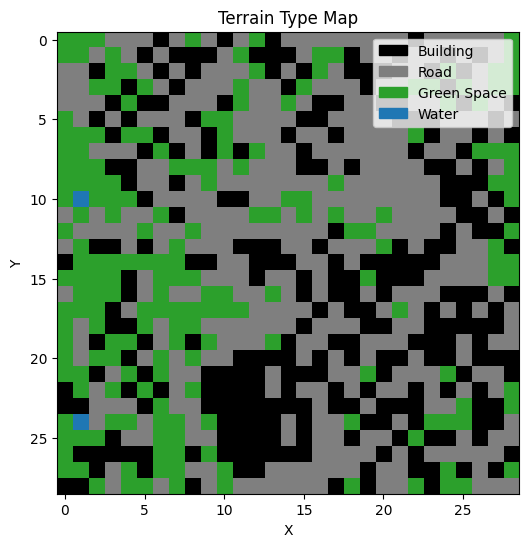

In [85]:
# ===============================================================
# Landuseplot
# ===============================================================
# Define the colormap and boundaries for terrain types
cmap_types = mcolors.ListedColormap(['black', 'tab:gray', 'tab:green', 'tab:blue'])
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
norm = mcolors.BoundaryNorm(bounds, cmap_types.N)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(type_pivot, origin='upper', cmap=cmap_types, norm=norm)
ax.set_title("Terrain Type Map")
ax.set_xlabel("X")
ax.set_ylabel("Y")

# Create legend patches
patch1 = mpatches.Patch(color='black', label='Building')
patch2 = mpatches.Patch(color='tab:gray', label='Road')
patch3 = mpatches.Patch(color='tab:green', label='Green Space')
patch4 = mpatches.Patch(color='tab:blue', label='Water')

ax.legend(handles=[patch1, patch2, patch3, patch4], loc='upper right')

plt.show()

## Initial Heatmap plot

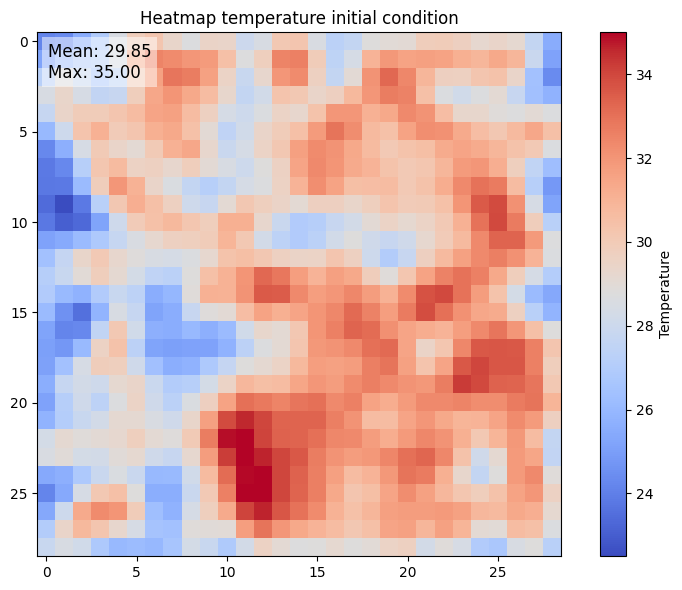

In [86]:
# ===============================================================
# Initial Heatmap plot
# ===============================================================
plt.figure(figsize=(8, 6))
plt.imshow(temp_matrix, origin='upper', cmap='coolwarm', vmin=vmin, vmax=vmax)
plt.title("Heatmap temperature initial condition")
cbar = plt.colorbar()
cbar.set_label("Temperature")

# Add a legend in the upper left corner with mean and max temperature values
plt.text(0.02, 0.98, f"Mean: {original_mean:.2f}\nMax: {original_max:.2f}",
         transform=plt.gca().transAxes,
         fontsize=12,
         verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

plt.tight_layout()
plt.show()

#### Heat Island Visualization

Temperature threshold (85th percentile): 32.33


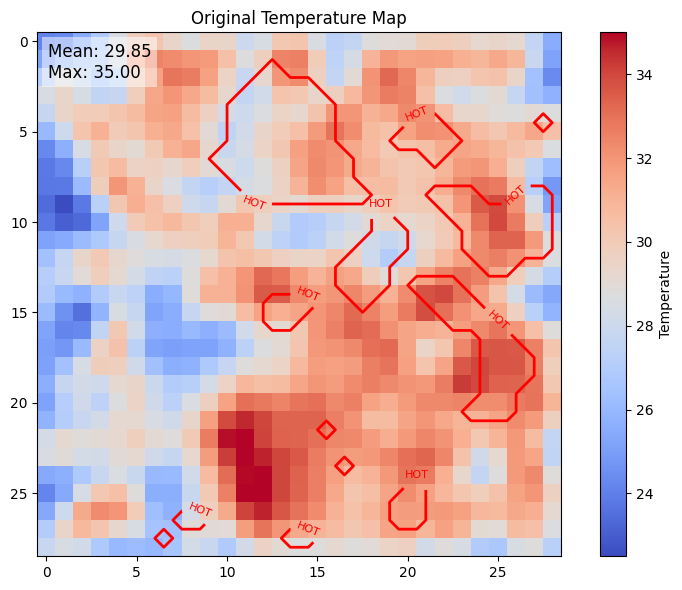

In [87]:
# ===============================================================
# 2. Plot the original map using imshow
# ===============================================================
plt.figure(figsize=(8, 6))
# Display the temperature map
img = plt.imshow(temp_matrix, origin='upper', cmap='coolwarm', vmin=vmin, vmax=vmax)
plt.title("Original Temperature Map")

# Colorbar
cbar = plt.colorbar(img)
cbar.set_label("Temperature")

# ===============================================================
# 3. Define threshold and mask for the hottest regions
# ===============================================================
threshold = np.percentile(temp_matrix, 85)  # 85th percentile (change if needed)
hot_mask = temp_matrix >= threshold
print(f"Temperature threshold (85th percentile): {threshold:.2f}")

# ===============================================================
# 4. Draw contours for the hottest regions
# ===============================================================
# To align the contours with imshow (which uses origin='upper'),
# we pass origin='upper'. Also, if you want the contours to align with the cells,
# you can specify 'extent' as [0, W, 0, H].
contours = plt.contour(
    hot_mask,
    levels=[0.5],       # Value halfway between False (0) and True (1)
    colors='red',       # Contour color
    linewidths=2,
    origin='upper'
)
plt.clabel(contours, inline=True, fontsize=8, fmt='HOT')

# Add a legend in the upper left corner with mean and max temperature values
plt.text(0.02, 0.98, f"Mean: {original_mean:.2f}\nMax: {original_max:.2f}",
         transform=plt.gca().transAxes,
         fontsize=12,
         verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
# If you want to highlight the inner cells (fill), you can use 'plt.contourf'
# or 'np.where' to create an overlay.

plt.tight_layout()
plt.show()

### Other Possibility
This can may be deleted if the hot_mask variable is added to the ACO

(np.float64(-0.5), np.float64(28.5), np.float64(28.5), np.float64(-0.5))

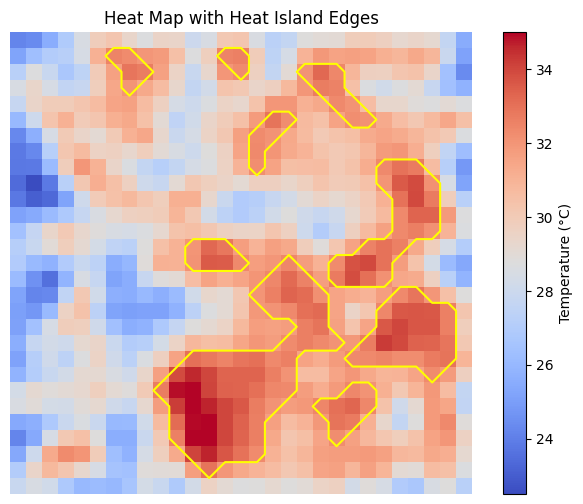

In [88]:
def get_heat_islands(temp_matrix,threshold=32):
  from sklearn.cluster import DBSCAN

  # Get grid dimensions
  H, W = temp_matrix.shape

  # Get all coordinates (y, x)
  y_coords, x_coords = np.indices((H, W))
  coords = np.column_stack((y_coords.ravel(), x_coords.ravel()))

  # Flatten temperature matrix
  temps = temp_matrix.ravel()

  # Select hot regions
  hot_mask = temps >= threshold
  hot_coords = coords[hot_mask]

  # Apply DBSCAN clustering to detect hot areas
  dbscan = DBSCAN(eps=1.5, min_samples=3)
  hot_clusters = dbscan.fit_predict(hot_coords)

  # Create cluster grid (initialize with -1)
  cluster_grid = np.full((H, W), fill_value=-1)
  for (y, x), cluster_label in zip(hot_coords, hot_clusters):
      cluster_grid[y, x] = cluster_label

  return cluster_grid,hot_clusters

def get_heat_island_edges(temp_matrix):


  cluster_grid,hot_clusters = get_heat_islands(temp_matrix)

  # Identify cluster edges
  edges = np.zeros_like(cluster_grid, dtype=bool)
  for cluster_label in np.unique(hot_clusters[hot_clusters >= 0]):
      cluster_mask = cluster_grid == cluster_label
      dilated_mask = binary_dilation(cluster_mask, structure=np.ones((3, 3)))  # Use a 3x3 structuring element
      edge = dilated_mask & cluster_mask  # Edges are within the hot regions
      edges |= edge

  return edges

plt.figure(figsize=(8, 6))

# Display temperature heatmap (fix mirroring with origin='upper')
plt.imshow(temp_matrix, cmap='coolwarm', interpolation='nearest', origin='upper')
plt.colorbar(label="Temperature (°C)")

# Overlay heat island edges (no need for extent if origin='upper' in imshow)
plt.contour(get_heat_island_edges(temp_matrix), colors='yellow', linewidths=1.5)

plt.title("Heat Map with Heat Island Edges")
plt.axis('off')

# 2.   General functions used in further parts

## Solution calculation functions

In [89]:
# ===============================================================
# 3. Solution calculation functions
# ===============================================================
def calculate_reduced_heatmap(solution):
    # Applying the cooling effect using a Gaussian model
    final_temp = np.copy(temp_matrix)
    Y, X = np.indices((H, W))
    for (row_center, col_center, candidate_type) in solution:
        sigma = tree_properties[candidate_type]['radius'] / 2.0
        dist2 = (Y - row_center)**2 + (X - col_center)**2
        effect = tree_properties[candidate_type]['cooling'] * np.exp(-dist2 / (2 * sigma**2))
        final_temp -= effect
    return final_temp


def calculate_objective_stats(heatmap):
    # Calculation of average temperature
    avg_temp = np.mean(heatmap)
    # Calculation of average hotspot temperature
    mean_hotspot_temp = np.mean(heatmap[hot_mask]) if np.any(hot_mask) else avg_temp  # Avoid NaN if no hotspots

    return avg_temp, mean_hotspot_temp

def calculate_used_budget(solution):
  budget_used = 0
  for (_,_,candidate_type) in solution:
      budget_used += tree_properties[candidate_type]['cost']
  return budget_used


## Solution text output functions

In [101]:
def print_solution_elements(solution, heading='Optimized Solution'):
  print(f"\n--- {heading} ---")
  print("Number of placements:", len(solution))
  for (row, col, candidate_type) in solution:
      print(f"Position: ({row}, {col}) - Type: {tree_properties[candidate_type]['name']}")

## Solution visualization functions

In [90]:
# ---------------------------------------------------
# 4. Solution visualization functions
# ---------------------------------------------------
def print_solution_map(solution):
    # calculate heatmap based on solution
    sol_temp = calculate_reduced_heatmap(solution)
    sol_avg, sol_hot_avg = calculate_objective_stats(sol_temp)
    sol_budget = calculate_used_budget(solution)

    # Heatmap Visualization for Random Insertion
    fig, ax = plt.subplots(figsize=(10,8))
    im = ax.imshow(sol_temp, origin='upper', cmap='coolwarm', vmin=vmin, vmax=vmax)
    ax.set_title("Optimized Temperature Map (Random Insertion)")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Temperature")

    # Overlay text: Mean, Max, and Budget Used
    ax.text(0.95, 0.95, f"Mean: {sol_avg:.2f}\nMax: {sol_hot_avg:.2f}\nBudget used: {sol_budget:.2f}",
            transform=ax.transAxes, fontsize=12, color='black',
            backgroundcolor='white', ha='right', va='top',
            bbox=dict(facecolor='white', alpha=0.8))

    # Overlay markers for each placement
    for (row, col, candidate_type) in solution:
        label = tree_properties[candidate_type]['name']
        ax.scatter(col, row, marker='o', s=100, edgecolor='black', color=tree_properties[candidate_type]['color'])
        ax.text(col, row, label, color=tree_properties[candidate_type]['color'],
                fontsize=10, fontweight='bold', ha='center', va='center')

    plt.show()

def print_solution_histogram(solution):
    sol_temp = calculate_reduced_heatmap(solution)
    # Histogram Visualization: Original vs. Random Insertion Optimized Temperature
    plt.figure(figsize=(8,6))
    plt.hist(temp_matrix.flatten(), bins=30, alpha=0.5, label='Original')
    plt.hist(sol_temp.flatten(), bins=30, alpha=0.5, label='Optimized (Random Insertion)')
    plt.title("Histogram of Temperatures: Original vs Optimized (Random Insertion)")
    plt.xlabel("Temperature")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 3.   Problem parameter description

## Parameter description

In [91]:
# ===============================================================
# 2. Problem parameters and properties of the cooling elements
# ===============================================================
num_candidates = 50   # Maximum number of candidates (potential placements)
budget_max = 10000     # Maximum budget in CHF

# Tree properties:
# Type 0: 'powerful' tree – high cost, greater cooling
# Type 1: 'economical' tree – lower cost, less cooling
tree_properties = {
    0: {'cost': 300, 'cooling': 6, 'radius': 1, 'name':'Powerful tree', 'color':'yellow'},
    1: {'cost': 300, 'cooling': 1, 'radius': 8, 'name':'Economical tree', 'color':'cyan'},
    2: {'cost': 3500, 'cooling': 4.5, 'radius': 4, 'name':'Fountain', 'color':'magenta'}
}

# Fountain properties
fountain_properties = tree_properties[2]


# Weight parameters for multi-objective optimization
# (These values will be redefined in the loop)
w_mean = 1.0   # Weight for average temperature
w_max  = 1.0   # Weight for maximum temperature (hot spot)

## Objective Function definition

In [92]:
# ===============================================================
# 5. Multi-Objective Function
# ===============================================================
# (The objective/objective_hotspots function is defined as in the original code,
#  and it uses the global weights w_mean and w_max to combine the two criteria

def objective(candidates):
    """
    Minimizes a multi-criteria objective function that combines the average temperature and
    the maximum final temperature after applying the cooling effect.

    The decision vector 'solution' has a dimension of 4 * num_candidates:
      [row1, col1, active1, type1, ..., rowN, colN, activeN, typeN]

    The possible values for 'type' are:
      - 0: "powerful" tree
      - 1: "economical" tree
      - 2: Fountain (can only be placed in 'green_space' areas)

    Penalties:
      - Position outside the grid.
      - Tree placed on a building.
      - Fountain placed in an area other than 'green_space'.
      - Total cost exceeding the budget.
      - Effect radius extending beyond the map.
    """
    penalty = 0
    total_cost = 0

    for (row,col,candidate_type) in candidates:
        # Check: valid position within the grid
        if row < 0 or row >= H or col < 0 or col >= W:
            penalty += 1e6
            continue

      # Specific checks for the element type
        if candidate_type == 2:
            # The fountain must be placed only in green_space areas
            if type_matrix[row, col] != type_to_num['green_space']:
                penalty += 1e6
        else:
            # Trees cannot be placed on a building
            if type_matrix[row, col] == type_to_num['building']:
                penalty += 1e6

        # Check that the effect radius does not extend beyond the map
        '''
        This should not be penalized in this way. It's a loss in general cooling effect, but no error!

        r_effect = props['radius']
        if (row - r_effect < 0 or row + r_effect >= H or col - r_effect < 0 or col + r_effect >= W):
            penalty += 1e6
        '''
        total_cost += tree_properties[candidate_type]['cost']

    # Penalty if the total cost exceeds the budget
    if total_cost > budget_max:
        penalty += 1e6 * (total_cost - budget_max)

    # Applying the cooling effect using a Gaussian model
    final_temp = calculate_reduced_heatmap(candidates)

    # Calculation of the two criteria: average temperature and mean hotspot temperature
    avg_temp, mean_hotspot_temp = calculate_objective_stats(final_temp)

    # Multi-criteria objective function: weighted combination
    objective_value = w_mean * avg_temp + w_max * mean_hotspot_temp + penalty
    return objective_value

# 4. Random Generation

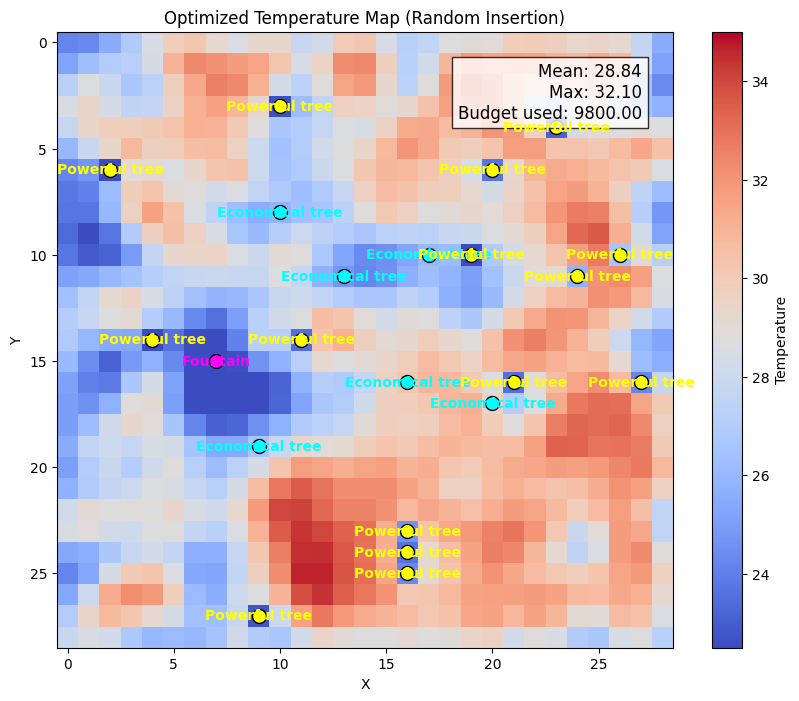

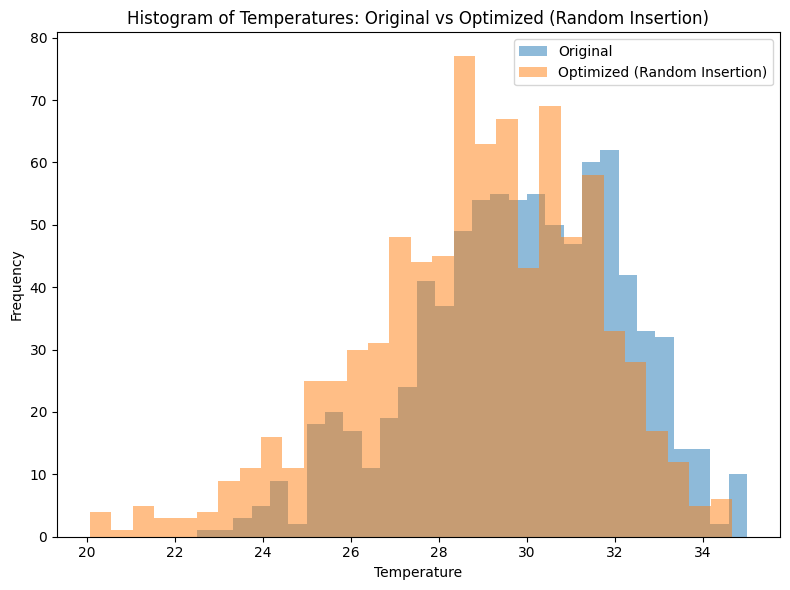

In [93]:
import random
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------
# Random Insertion Under Restrictions
# ---------------------------------------------------
def random_insertion(type_matrix, budget_max):
    """
    Randomly insert candidates (trees and fountains) on the grid.
    The restrictions are:
      - Fountain (type 2) can only be placed on cells where type_matrix == type_to_num['green_space'].
      - Trees (types 0 and 1) cannot be placed on cells where type_matrix == type_to_num['building'].
      - The candidate's effect radius must fit inside the grid.
      - Total cost must not exceed budget_max.
    Returns:
      placed_elements: List of tuples (row, col, candidate_type)
      total_cost: Total cost used.
    """
    H, W = type_matrix.shape
    placed_elements = []  # List of (row, col, candidate_type)
    total_cost = 0

    # Calculate the minimum candidate cost (used to check if further placements are possible)
    min_tree_cost = min(tree_properties[t]['cost'] for t in tree_properties)
    min_candidate_cost = min(min_tree_cost, fountain_properties['cost'])

    used_cells = set()
    max_iterations = H * W * 10  # Avoid infinite loops
    iterations = 0

    while total_cost + min_candidate_cost <= budget_max and iterations < max_iterations:
        iterations += 1
        # Randomly choose a cell
        row = random.randint(0, H-1)
        col = random.randint(0, W-1)

        # Randomly select a candidate type (0: Powerful tree, 1: Economical tree, 2: Fountain)
        candidate_type = random.choice([0, 1, 2])

        # Restriction: Fountain only on green_space
        if candidate_type == 2:
            if type_matrix[row, col] != type_to_num['green_space']:
                continue
            cost = fountain_properties['cost']
        else:
            # Trees cannot be placed on a building
            if type_matrix[row, col] == type_to_num['building']:
                continue
            cost = tree_properties[candidate_type]['cost']

        # Check if a candidate has already been placed in this cell
        if (row, col) in used_cells:
            continue

        # Check if placing this candidate would exceed the budget
        if total_cost + cost > budget_max:
            continue

        # Check that the candidate's effect radius does not extend beyond the grid boundaries
        r_effect = tree_properties[candidate_type]['radius']
        if (row - r_effect < 0 or row + r_effect >= H or
            col - r_effect < 0 or col + r_effect >= W):
            continue

        # All restrictions passed: add candidate
        placed_elements.append((row, col, candidate_type))
        used_cells.add((row, col))
        total_cost += cost

    return placed_elements, total_cost

# Run random insertion
random_solution, total_cost_random = random_insertion(type_matrix, budget_max)

print_solution_map(random_solution)
print_solution_histogram(random_solution)


# 3. Genetic algorithms

## GA Parameter

In [102]:
# ===============================================================
# 4. Definition of the decision vector for the GA
# ===============================================================
# Each candidate has 4 variables: row, col, active, type
var_bound = []
for _ in range(num_candidates):
    var_bound.append([0, H-1])  # row
    var_bound.append([0, W-1])  # col
    var_bound.append([0, 1])    # active
    var_bound.append([0, 2])    # type
var_bound = np.array(var_bound)

# ===============================================================
# 5. Parametri dell'algoritmo genetico
# ===============================================================
params = {
    'max_num_iteration': 5,
    'population_size': 500,
    'mutation_probability': 0.2,
    'elit_ratio': 0.05,
    'crossover_probability': 0.7,
    'parents_portion': 0.3,
    'crossover_type': 'uniform',
    'max_iteration_without_improv': 100
}


def decode_ga_solution(ga_solution):
  candidates = []
  for i in range(num_candidates):
    if int(round(ga_solution[4*i+2])) >= 1:
      row = int(round(ga_solution[4*i]))
      col = int(round(ga_solution[4*i+1]))
      candidate_type = int(round(ga_solution[4*i+3]))
      candidate_type = max(0, min(2, candidate_type))  # Force candidate_type in [0,2]
      candidates.append((row, col, candidate_type))

  return candidates

def objective_ga(solution):
    return objective(decode_ga_solution(solution))

## GA weight optimisation

Executing GA with w_mean = 1.0 and w_max = 0.0 for 1 runs
 The best solution found:                                                                           
 [14. 15.  1.  1. 21. 24.  0.  0.  7. 17.  0.  1. 18. 12.  1.  0. 20.  8.
  1.  0. 13. 25.  0.  1. 22. 10.  0.  0. 20. 22.  0.  2. 27. 10.  1.  0.
 20.  8.  1.  0.  3. 11.  0.  2. 19. 16.  0.  0.  7. 22.  0.  1. 25. 19.
  0.  1. 20.  0.  0.  0. 19. 13.  1.  0.  9. 16.  1.  0. 12.  4.  0.  0.
 21. 28.  0.  1.  1.  0.  0.  2.  3. 20.  0.  1. 15. 27.  0.  1.  7. 24.
  0.  1. 25.  3.  0.  0.  9. 27.  1.  0.  4.  0.  0.  1.  6.  8.  0.  1.
  6. 11.  0.  2.  1. 23.  0.  1. 15. 14.  1.  1. 11. 21.  0.  2. 20. 18.
  0.  2.  9. 24.  0.  1. 14.  4.  1.  2. 23. 11.  0.  0. 11. 20.  1.  1.
 11. 26.  0.  0.  3.  9.  0.  2.  8. 14.  1.  0.  8.  2.  0.  1. 16.  4.
  0.  2. 23. 10.  0.  1.  4.  6.  0.  2.  0. 19.  0.  1. 20. 19.  1.  0.
 19. 18.  0.  2. 12. 28.  0.  1.  2. 11.  0.  2.  6.  4.  0.  0.  6. 25.
  0.  1.]

 Objective function:
 29.2

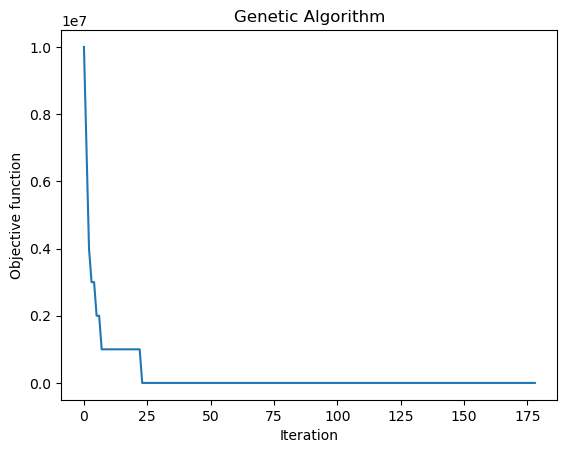


Average statistics for w_mean=1.0, w_max=0.0:
{'mean': 28.56733650416171, 'max': 35.0, 'min': 14.16, 'var': 10.609328220890989, 'median': 29.11, 'perc_mean': 4.307627108855316, 'perc_max': 0.0}



Executing GA with w_mean = 0.75 and w_max = 0.25 for 1 runs
||||______________________________________________ 8.1% GA is running...

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.colors as mcolors

# ---------------------------
# Optimization runs for different weight combinations
# ---------------------------
# Number of runs for each weight combination
num_runs_per_weight = 1

# Define the weight combinations: from 100% w_mean to 0%
weight_settings = [
    (1.0, 0.0),    # 100% average, 0% hot spot
    (0.75, 0.25),  # 75% average, 25% hot spot
    (0.5, 0.5),    # 50% average, 50% hot spot
    (0.25, 0.75),  # 25% average, 75% hot spot
    (0.0, 1.0)     # 0% average, 100% hot spot
]

# Dictionary to store the aggregated results for each combination
results = {}

for (w_mean_val, w_max_val) in weight_settings:
    # Update the global weights (used in the objective function)
    w_mean = w_mean_val
    w_max = w_max_val
    print("===========================================")
    print(f"Executing GA with w_mean = {w_mean} and w_max = {w_max} for {num_runs_per_weight} runs")
    print("===========================================")

    # Lists to store the final temperature maps and statistics for each run
    final_temp_list = []
    stats_list = []

    for run in range(num_runs_per_weight):
        # Execute the GA for the current run
        model = ga(function=objective_ga,
                   dimension=4 * num_candidates,
                   variable_type='int',
                   variable_boundaries=var_bound,
                   algorithm_parameters=params)
        model.run()
        best_sol = model.output_dict['variable']
        # Extract the placed elements from the best solution
        placed_elements = []
        total_cost = 0
        for i in range(num_candidates):
            row = int(round(best_sol[4*i]))
            col = int(round(best_sol[4*i + 1]))
            active = 1 if int(round(best_sol[4*i + 2])) >= 1 else 0
            candidate_type = int(round(best_sol[4*i + 3]))
            candidate_type = max(0, min(2, candidate_type))
            if active:
                if candidate_type == 2:
                    total_cost += fountain_properties['cost']
                else:
                    total_cost += tree_properties[candidate_type]['cost']
                placed_elements.append((row, col, candidate_type))

        # Calculate the final temperature map for the current run
        final_temp_opt = np.copy(temp_matrix)
        Y, X = np.indices((H, W))
        for (row_center, col_center, candidate_type) in placed_elements:
            if candidate_type == 2:
                props = fountain_properties
            else:
                props = tree_properties[candidate_type]
            rad = props['radius']
            cool = props['cooling']
            mask = (Y - row_center)**2 + (X - col_center)**2 <= rad**2
            final_temp_opt[mask] -= cool

        # Calculate statistics for this run
        final_mean = np.mean(final_temp_opt)
        final_max = np.max(final_temp_opt)
        final_min = np.min(final_temp_opt)
        final_var = np.var(final_temp_opt)
        final_median = np.median(final_temp_opt)
        # Calculate the percentage improvements relative to the original values
        perc_mean = 100 * (original_mean - final_mean) / original_mean
        perc_max = 100 * (original_max - final_max) / original_max

        print(f"Run {run+1}: Mean = {final_mean:.2f}, Max = {final_max:.2f}, Perc_mean = {perc_mean:.2f}%, Perc_max = {perc_max:.2f}%")

        final_temp_list.append(final_temp_opt)
        stats_list.append({
            'mean': final_mean,
            'max': final_max,
            'min': final_min,
            'var': final_var,
            'median': final_median,
            'perc_mean': perc_mean,
            'perc_max': perc_max
        })

    # Calculate the average final temperature map obtained from the runs
    avg_final_temp = np.mean(np.array(final_temp_list), axis=0)
    # Calculate the average statistics (the mean is computed over the runs for each metric)
    avg_stats = {key: np.mean([s[key] for s in stats_list]) for key in stats_list[0]}

    # Store the aggregated results for this weight combination
    results[(w_mean, w_max)] = {
         'avg_final_temp': avg_final_temp,
         'avg_stats': avg_stats,
         'final_temp_list': final_temp_list,
         'stats_list': stats_list
    }

    print(f"Average statistics for w_mean={w_mean}, w_max={w_max}:")
    print(avg_stats)
    print("\n\n")

# ---------------------------
# Plot: Bar chart of average improvements for each weight combination
# ---------------------------
# Create lists for the labels and average improvements
weight_labels = []
avg_improvements = []  # Average of (perc_mean and perc_max) for each combination

for (w_mean, w_max), res in results.items():
    weight_labels.append(f"w_mean={w_mean}\nw_max={w_max}")
    # Calculate the average improvement using the average statistics
    avg_impr = (res['avg_stats']['perc_mean'] + res['avg_stats']['perc_max']) / 2
    avg_improvements.append(avg_impr)

x = np.arange(len(weight_labels))
bar_width = 0.5

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x, avg_improvements, bar_width, color='skyblue', label='Average improvements (%)')

# Add labels and titles
ax.set_ylabel('Average improvements (%)')
ax.set_title('Average improvements for different weight combinations')
ax.set_xticks(x)
ax.set_xticklabels(weight_labels)
ax.legend()

# Add values on top of the bars
for i, v in enumerate(avg_improvements):
    ax.text(x[i], v + 0.5, f"{v:.2f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# ---------------------------
# Plot: Histograms comparing the original and optimized temperature distributions
# ---------------------------
num_settings = len(results)
ncols = 2
nrows = math.ceil(num_settings / ncols)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 6*nrows))
axs = axs.flatten()

for idx, ((w_mean, w_max), res) in enumerate(results.items()):
    ax = axs[idx]
    avg_final_temp = res['avg_final_temp']
    # Histogram of the original temperature distribution
    ax.hist(temp_matrix.flatten(), bins=30, alpha=0.5, label='Original')
    # Histogram of the average final distribution (over runs)
    ax.hist(avg_final_temp.flatten(), bins=30, alpha=0.5, label='Optimized (average over runs)')
    ax.set_title(f"w_mean={w_mean}, w_max={w_max}\n"
                 f"Perc_mean = {res['avg_stats']['perc_mean']:.2f}%, Perc_max = {res['avg_stats']['perc_max']:.2f}%")
    ax.set_xlabel("Temperature")
    ax.set_ylabel("Frequency")
    ax.legend()

# Remove any extra subplots
for j in range(idx+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


In [104]:
# Create lists for the labels and individual improvements
weight_labels = []
perc_means = []
perc_maxs = []

for (w_mean, w_max), res in results.items():
    weight_labels.append(f"w_mean={w_mean}\nw_max={w_max}")
    perc_means.append(res['avg_stats']['perc_mean'])
    perc_maxs.append(res['avg_stats']['perc_max'])

x = np.arange(len(weight_labels))
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, perc_means, width, label='Average improvement (%)')
bars2 = ax.bar(x + width/2, perc_maxs, width, label='Hot spot improvement (%)')

ax.set_ylabel('Improvement (%)')
ax.set_title('Improvements of the average and the hottest point for each weight combination')
ax.set_xticks(x)
ax.set_xticklabels(weight_labels)
ax.legend()

plt.tight_layout()
plt.show()



NameError: name 'results' is not defined

## Single-Run

 The best solution found:
 [ 3.  9.  0.  1.  6.  7.  0.  1. 22. 13.  1.  1. 11. 25.  0.  0. 24. 25.
  0.  0.  6. 17.  0.  0. 10.  7.  1.  1. 20. 13.  0.  1. 22. 17.  0.  1.
 23. 11.  0.  2. 14.  6.  1.  0. 15. 15.  0.  0. 12.  7.  0.  1.  4. 10.
  0.  0.  8. 25.  1.  1. 24.  6.  0.  1.  2. 11.  0.  1. 14. 28.  1.  0.
 13. 10.  1.  0. 25. 12.  0.  0. 16. 14.  0.  2. 14. 26.  0.  0. 19. 27.
  0.  1. 11. 20.  0.  0. 21.  1.  0.  1. 10.  4.  1.  2. 11. 20.  0.  1.
 16. 16.  1.  1.  7.  5.  0.  2. 14. 17.  0.  0.  7.  8.  0.  1.  4. 26.
  1.  1. 25. 14.  0.  0. 18. 13.  0.  1. 27. 10.  0.  0. 23. 17.  0.  0.
  5.  3.  0.  1.  2. 25.  0.  0. 19. 28.  0.  0.  7.  6.  0.  1. 15.  2.
  0.  1. 21. 19.  0.  0. 27.  7.  0.  1.  9.  5.  1.  1. 16.  8.  0.  1.
  4. 14.  0.  0.  1. 17.  0.  1. 11. 12.  0.  2. 13. 14.  0.  2.  8. 13.
  0.  2.]

 Objective function:
 30.74066343667984


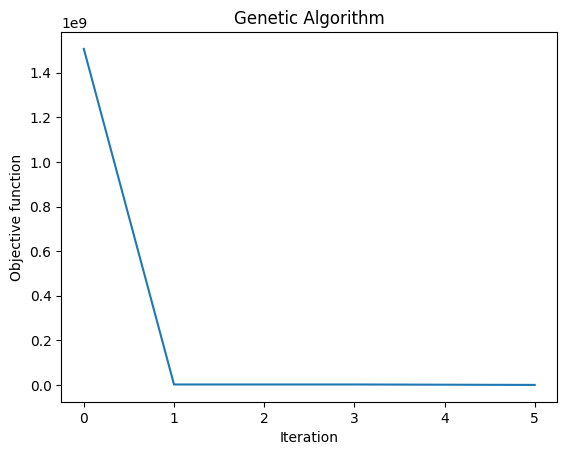


--- Single Run Result (50/50 Weighting) ---
Best solution found: [ 3.  9.  0.  1.  6.  7.  0.  1. 22. 13.  1.  1. 11. 25.  0.  0. 24. 25.
  0.  0.  6. 17.  0.  0. 10.  7.  1.  1. 20. 13.  0.  1. 22. 17.  0.  1.
 23. 11.  0.  2. 14.  6.  1.  0. 15. 15.  0.  0. 12.  7.  0.  1.  4. 10.
  0.  0.  8. 25.  1.  1. 24.  6.  0.  1.  2. 11.  0.  1. 14. 28.  1.  0.
 13. 10.  1.  0. 25. 12.  0.  0. 16. 14.  0.  2. 14. 26.  0.  0. 19. 27.
  0.  1. 11. 20.  0.  0. 21.  1.  0.  1. 10.  4.  1.  2. 11. 20.  0.  1.
 16. 16.  1.  1.  7.  5.  0.  2. 14. 17.  0.  0.  7.  8.  0.  1.  4. 26.
  1.  1. 25. 14.  0.  0. 18. 13.  0.  1. 27. 10.  0.  0. 23. 17.  0.  0.
  5.  3.  0.  1.  2. 25.  0.  0. 19. 28.  0.  0.  7.  6.  0.  1. 15.  2.
  0.  1. 21. 19.  0.  0. 27.  7.  0.  1.  9.  5.  1.  1. 16.  8.  0.  1.
  4. 14.  0.  0.  1. 17.  0.  1. 11. 12.  0.  2. 13. 14.  0.  2.  8. 13.
  0.  2.]

--- Single Run Result (50/50 Weighting) ---
Number of placements: 10
Position: (22, 13) - Type: Economical tree
Position

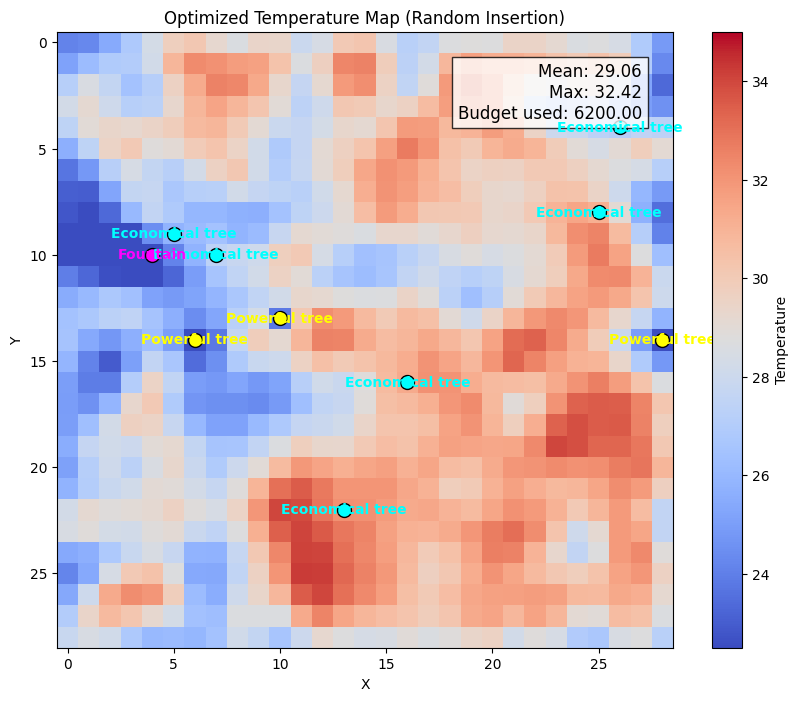

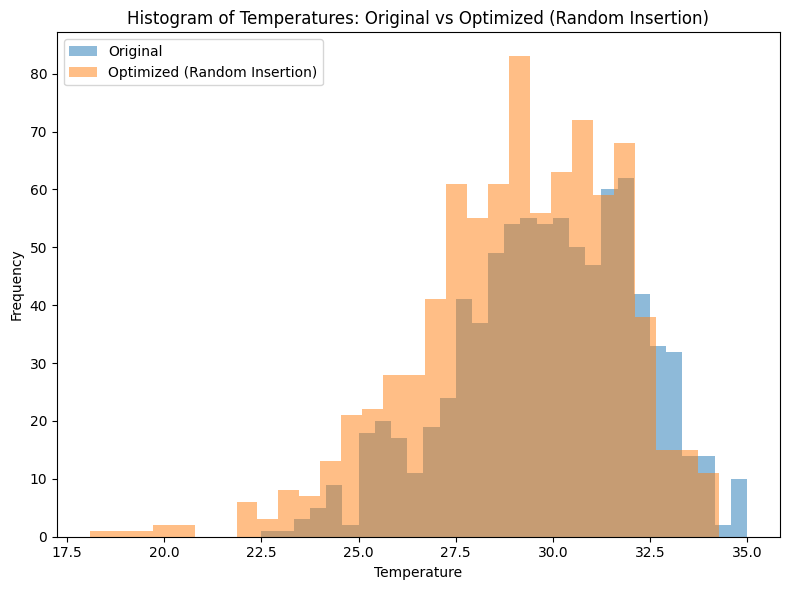

In [103]:
# ---------------------------
# Settings and 50/50 Run (already executed)
# ---------------------------
# Set the 50/50 weighting
w_mean = 0.5   # Weight for the average temperature
w_max  = 0.5   # Weight for the maximum temperature (hot spot)

# Execute a single run (modify 'objective_hotspots' if necessary)
model = ga(function=objective_ga,
           dimension=4 * num_candidates,
           variable_type='int',
           variable_boundaries=var_bound,
           algorithm_parameters=params)

model.run()
best_sol = model.output_dict['variable']
print("\n--- Single Run Result (50/50 Weighting) ---")
print("Best solution found:", best_sol)

ga_solution = decode_ga_solution(best_sol)

print_solution_elements(ga_solution,heading='Single Run Result (50/50 Weighting)')
print("Total cost:", calculate_used_budget(ga_solution))

print_solution_map(ga_solution)
print_solution_histogram(ga_solution)



# 4. ACO

### Pheromone definition

In [105]:
# -------------------------------------------------
# Update pheromone and probabilistic selection
# -------------------------------------------------
def update_pheromone(best_solution, pheromone, evaporation_rate=0.05, reinforcement=0.3):
    """Update pheromone levels with evaporation and reinforcement."""
    pheromone *= (1 - evaporation_rate)
    for (row, col, candidate_type) in best_solution:
        pheromone[row, col] += reinforcement

### Probabilistic Selection

In [106]:
def probabilistic_selection(type_matrix, pheromone, budget_remaining):
    """
    Select a cell and candidate type based on pheromone levels and cost constraints.
    Candidate types:
      0: Powerful tree
      1: Economical tree
      2: Fountain (only allowed on green_space)
    Trees cannot be placed on a building.
    """
    feasible_choices = []
    H, W = type_matrix.shape
    for row in range(H):
        for col in range(W):
            # Check each candidate type for the cell
            for candidate_type in [0, 1, 2]:
                if candidate_type == 2:
                    # Fountain can only be placed in green_space areas.
                    if type_matrix[row, col] != type_to_num['green_space']:
                        continue
                    cost = fountain_properties['cost']
                    cooling = fountain_properties['cooling']
                else:
                    # Trees (types 0 and 1) cannot be placed on a building.
                    if type_matrix[row, col] == type_to_num['building']:
                        continue
                    cost = tree_properties[candidate_type]['cost']
                    cooling = tree_properties[candidate_type]['cooling']
                if cost <= budget_remaining:
                    # Use pheromone level and cooling effect to compute a probability weight.
                    probability = pheromone[row, col] * cooling
                    feasible_choices.append((candidate_type, (row, col), probability))
    if not feasible_choices:
        return None, None
    candidate_types, indices, probabilities = zip(*feasible_choices)
    chosen_idx = random.choices(range(len(feasible_choices)), weights=probabilities, k=1)[0]
    return candidate_types[chosen_idx], indices[chosen_idx]


### ACO parameter

In [107]:
# -------------------------------------------------
# Ant Colony Optimization (ACO)
# -------------------------------------------------
def ant_colony_optimization(type_matrix, temp_matrix, tree_properties,
                            iterations=200, num_ants=10,
                            alpha=1.0, beta=1.0, cost_factor=1.5,
                            evaporation_rate=0.05, reinforcement=0.3):
    """
    Ant Colony Optimization for tree and fountain placement with grid-based constraints.

    The solution is evaluated using the same objective as in the GA:
      objective_value = w_mean * avg_temp + w_max * max_temp
    (Lower objective values are better, so we set quality = -objective_value.)
    """
    # Get heat islands (used in evaluation) from the temperature matrix.
    cluster_grid, _ = get_heat_islands(temp_matrix)
    # Determine the minimum cost among all candidate types.
    min_cost_tree = min(tree_properties[t]['cost'] for t in tree_properties)
    min_candidate_cost = min(min_cost_tree, fountain_properties['cost'])

    H, W = type_matrix.shape
    pheromone = np.ones((H, W))
    best_solution = []
    best_quality = float('inf')

    for _ in range(iterations):
        for _ in range(num_ants):
            solution = []
            budget_remaining = budget_max
            used_cells = set()
            while budget_remaining >= min_candidate_cost:
                candidate_type, pos = probabilistic_selection(type_matrix, pheromone, budget_remaining)
                if candidate_type is None or pos in used_cells:
                    break
                row, col = pos
                cost = tree_properties[candidate_type]['cost']
                if budget_remaining >= cost:
                    solution.append((row, col, candidate_type))
                    used_cells.add(pos)
                    budget_remaining -= cost

            objective_value = objective(solution)
            if objective_value < best_quality:
                best_solution = solution
                best_quality = objective_value
        update_pheromone(best_solution, pheromone, evaporation_rate, reinforcement)
    return best_solution


### ACO Result

In [108]:
# -------------------------------------------------
# Run ACO and display the results
# -------------------------------------------------
aco_solution = ant_colony_optimization(type_matrix, temp_matrix, tree_properties,
                                       iterations=200, num_ants=10,
                                       alpha=1.0, beta=1.0, cost_factor=1.5,
                                       evaporation_rate=0.05, reinforcement=0.3)


print_solution_elements(aco_solution,heading='ACO Result')
print("Total cost:", calculate_used_budget(aco_solution)




--- ACO Solution ---
Number of placements: 22
Position: (19, 10) - Type: Powerful tree
Position: (7, 28) - Type: Powerful tree
Position: (19, 13) - Type: Economical tree
Position: (28, 2) - Type: Powerful tree
Position: (3, 8) - Type: Powerful tree
Position: (5, 13) - Type: Powerful tree
Position: (18, 21) - Type: Powerful tree
Position: (10, 7) - Type: Powerful tree
Position: (16, 16) - Type: Powerful tree
Position: (28, 7) - Type: Powerful tree
Position: (6, 1) - Type: Fountain
Position: (4, 7) - Type: Economical tree
Position: (7, 1) - Type: Powerful tree
Position: (14, 18) - Type: Economical tree
Position: (20, 3) - Type: Economical tree
Position: (25, 20) - Type: Economical tree
Position: (16, 7) - Type: Powerful tree
Position: (20, 19) - Type: Powerful tree
Position: (22, 27) - Type: Economical tree
Position: (18, 22) - Type: Powerful tree
Position: (21, 17) - Type: Economical tree
Position: (15, 1) - Type: Economical tree


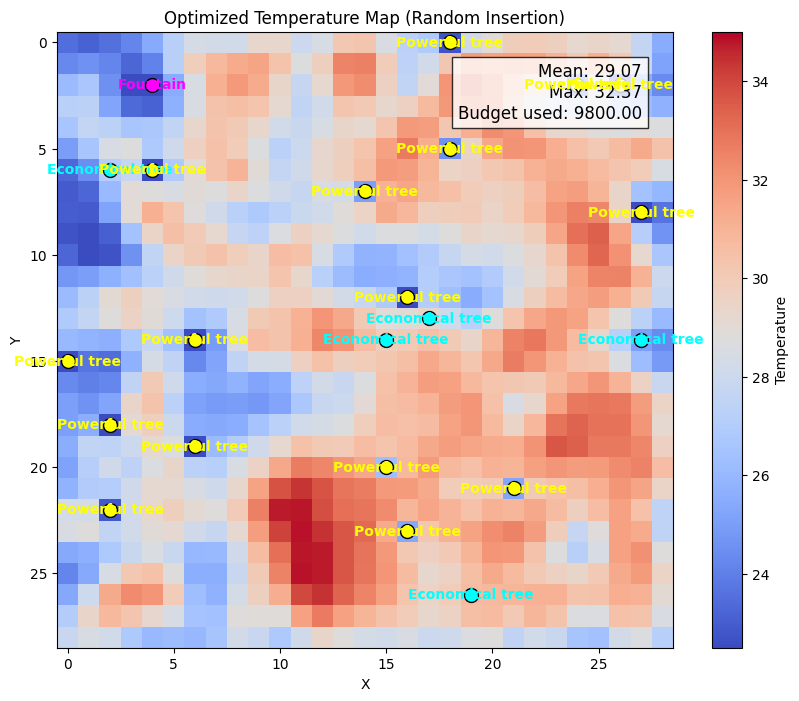

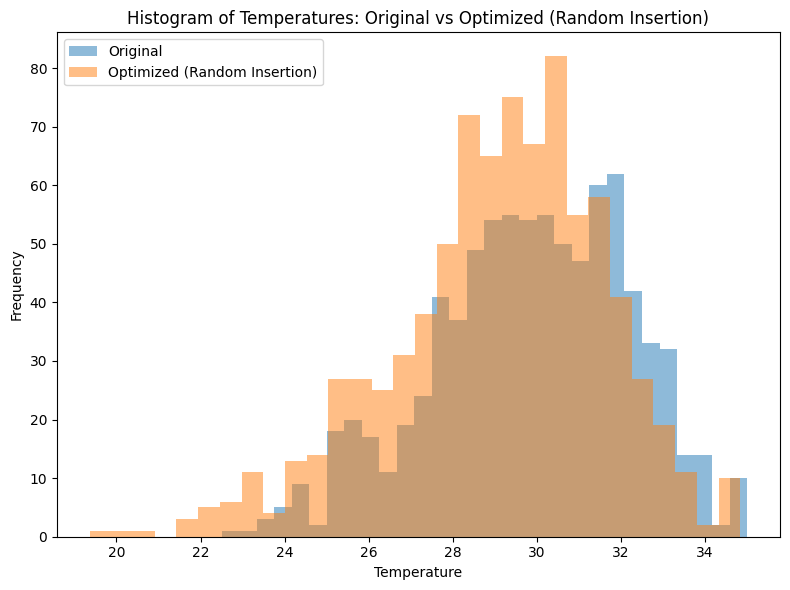

In [100]:
# ---------------------------
# Compute the final temperature map for the ACO solution
# ---------------------------
print_solution_map(aco_solution)
print_solution_histogram(aco_solution)

# 5. Summary

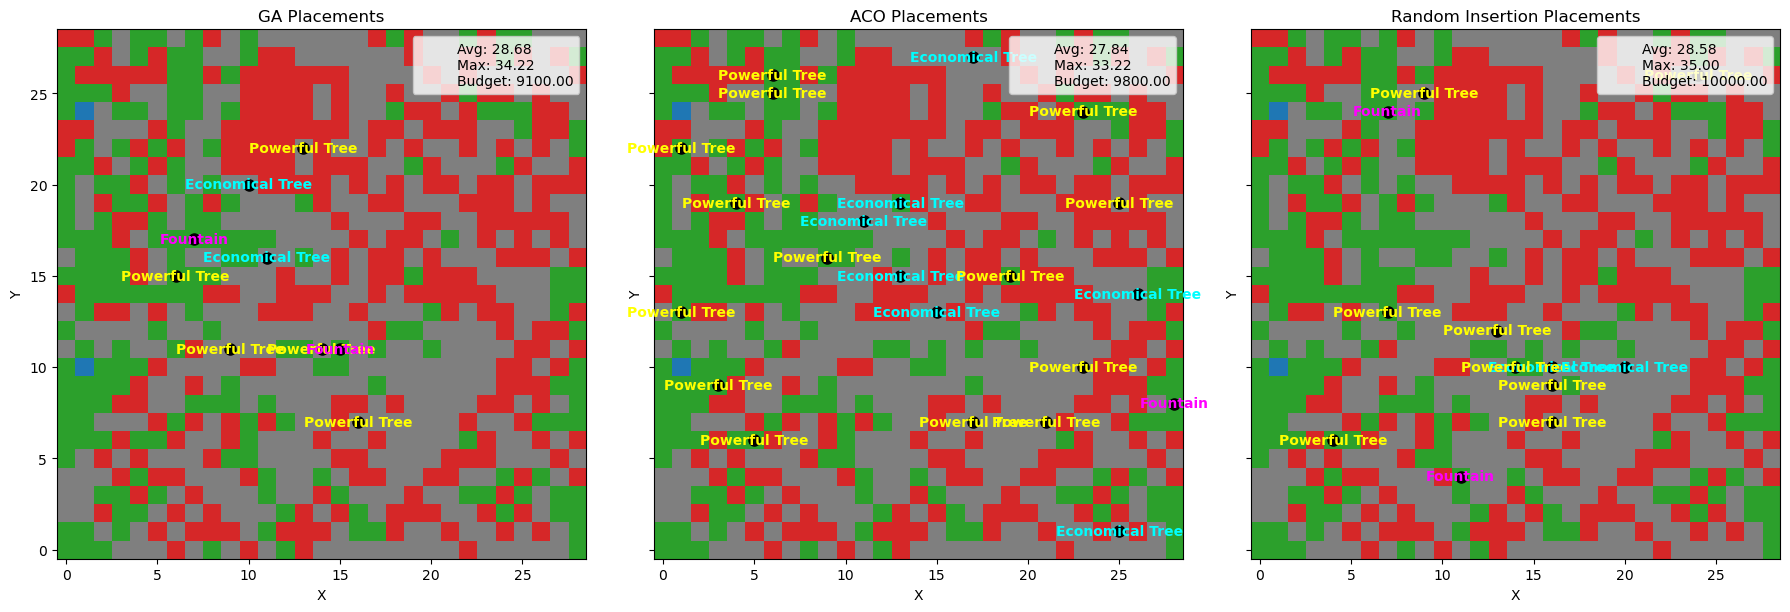

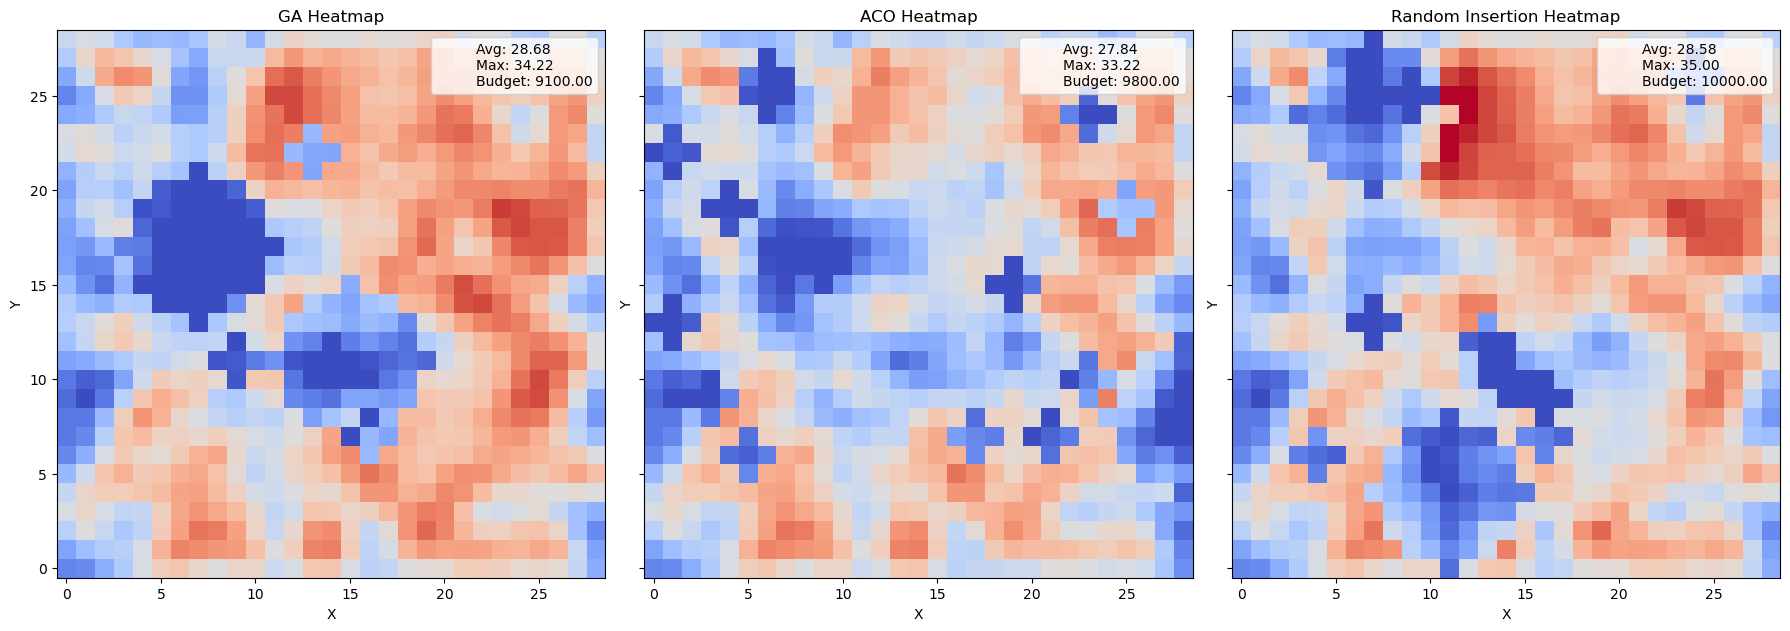

()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

def draw_placements(ax, placements):
    """
    Draw candidate placements on a given axis.
    Each placement is shown as a marker at its center with a label.
    """
    # Define colors for each candidate type
    tree_color = {0: 'yellow', 1: 'cyan', 2: 'magenta'}

    for (row, col, candidate_type) in placements:
        if candidate_type == 2:
            label = "Fountain"
        elif candidate_type == 0:
            label = "Powerful Tree"
        else:
            label = "Economical Tree"
        # Plot marker at candidate's center
        ax.plot(col, row, 'ko', markersize=8)
        # Add label at candidate's center
        ax.text(col, row, label, color=tree_properties[candidate_type]['color'],
                fontsize=10, fontweight='bold', ha='center', va='center')

# Define the colormap and boundaries for the terrain map
cmap_types = mcolors.ListedColormap(['tab:red', 'tab:gray', 'tab:green', 'tab:blue'])
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
norm = mcolors.BoundaryNorm(bounds, cmap_types.N)

# ========================
# 1. Placements Visualization
# ========================
fig, axs = plt.subplots(1, 3, figsize=(18, 8), sharex=True, sharey=True)

# GA placements on terrain map
axs[0].imshow(type_pivot, origin='upper', cmap=cmap_types, norm=norm)
draw_placements(axs[0], placed_elements)
axs[0].set_title("GA Placements")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
ga_metrics = mpatches.Patch(facecolor='none', label=f"Avg: {final_mean:.2f}\nMax: {final_max:.2f}\nBudget: {total_cost:.2f}")
axs[0].legend(handles=[ga_metrics], loc='upper right')

# ACO placements on terrain map
axs[1].imshow(type_pivot, origin='upper', cmap=cmap_types, norm=norm)
draw_placements(axs[1], aco_solution)
axs[1].set_title("ACO Placements")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
aco_metrics = mpatches.Patch(facecolor='none', label=f"Avg: {final_mean_aco:.2f}\nMax: {final_max_aco:.2f}\nBudget: {budget_used_aco:.2f}")
axs[1].legend(handles=[aco_metrics], loc='upper right')

# Random Insertion placements on terrain map
axs[2].imshow(type_pivot, origin='upper', cmap=cmap_types, norm=norm)
draw_placements(axs[2], random_solution)
axs[2].set_title("Random Insertion Placements")
axs[2].set_xlabel("X")
axs[2].set_ylabel("Y")
random_metrics = mpatches.Patch(facecolor='none', label=f"Avg: {final_mean_random:.2f}\nMax: {final_max_random:.2f}\nBudget: {total_cost_random:.2f}")
axs[2].legend(handles=[random_metrics], loc='upper right')

plt.tight_layout()
plt.show()

# ========================
# 2. Heatmaps Visualization
# ========================
fig2, axs2 = plt.subplots(1, 3, figsize=(18, 8), sharex=True, sharey=True)

# GA Heatmap
im0 = axs2[0].imshow(final_temp_opt, origin='upper', cmap='coolwarm', vmin=vmin, vmax=vmax)
axs2[0].set_title("GA Heatmap")
axs2[0].set_xlabel("X")
axs2[0].set_ylabel("Y")
ga_metrics_hm = mpatches.Patch(facecolor='none', label=f"Avg: {final_mean:.2f}\nMax: {final_max:.2f}\nBudget: {total_cost:.2f}")
axs2[0].legend(handles=[ga_metrics_hm], loc='upper right')

# ACO Heatmap
im1 = axs2[1].imshow(final_temp_aco, origin='upper', cmap='coolwarm', vmin=vmin, vmax=vmax)
axs2[1].set_title("ACO Heatmap")
axs2[1].set_xlabel("X")
axs2[1].set_ylabel("Y")
aco_metrics_hm = mpatches.Patch(facecolor='none', label=f"Avg: {final_mean_aco:.2f}\nMax: {final_max_aco:.2f}\nBudget: {budget_used_aco:.2f}")
axs2[1].legend(handles=[aco_metrics_hm], loc='upper right')

# Random Insertion Heatmap
im2 = axs2[2].imshow(final_temp_random, origin='upper', cmap='coolwarm', vmin=vmin, vmax=vmax)
axs2[2].set_title("Random Insertion Heatmap")
axs2[2].set_xlabel("X")
axs2[2].set_ylabel("Y")
random_metrics_hm = mpatches.Patch(facecolor='none', label=f"Avg: {final_mean_random:.2f}\nMax: {final_max_random:.2f}\nBudget: {total_cost_random:.2f}")
axs2[2].legend(handles=[random_metrics_hm], loc='upper right')

plt.tight_layout()
plt.show()
()


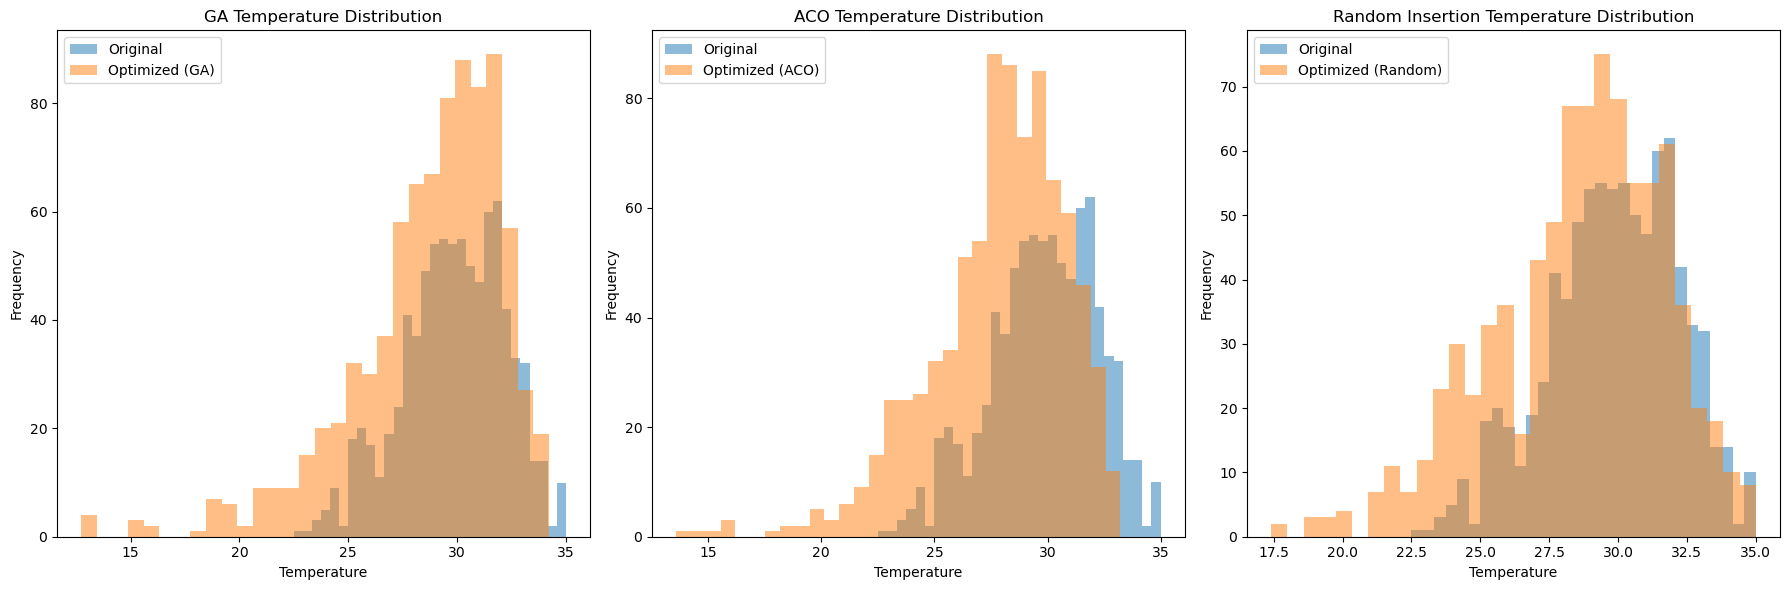

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with 3 subplots for the histograms
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# GA Histogram: Original vs Optimized (GA)
axs[0].hist(temp_matrix.flatten(), bins=30, alpha=0.5, label='Original')
axs[0].hist(final_temp_opt.flatten(), bins=30, alpha=0.5, label='Optimized (GA)')
axs[0].set_title("GA Temperature Distribution")
axs[0].set_xlabel("Temperature")
axs[0].set_ylabel("Frequency")
axs[0].legend()

# ACO Histogram: Original vs Optimized (ACO)
axs[1].hist(temp_matrix.flatten(), bins=30, alpha=0.5, label='Original')
axs[1].hist(final_temp_aco.flatten(), bins=30, alpha=0.5, label='Optimized (ACO)')
axs[1].set_title("ACO Temperature Distribution")
axs[1].set_xlabel("Temperature")
axs[1].set_ylabel("Frequency")
axs[1].legend()

# Random Insertion Histogram: Original vs Optimized (Random)
axs[2].hist(temp_matrix.flatten(), bins=30, alpha=0.5, label='Original')
axs[2].hist(final_temp_random.flatten(), bins=30, alpha=0.5, label='Optimized (Random)')
axs[2].set_title("Random Insertion Temperature Distribution")
axs[2].set_xlabel("Temperature")
axs[2].set_ylabel("Frequency")
axs[2].legend()

plt.tight_layout()
plt.show()
